In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Building a Chatbot

## Simple Chatbot

In [3]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
import os

In [4]:
load_dotenv(override=True)

True

In [5]:
#Check for environment variables
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [6]:
#Make sure this exists
_set_env("GROQ_API_KEY")

In [7]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [8]:
class SimpleChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
def simple_chatbot(state: SimpleChatState):
    return {
        "messages": [llm.invoke(state["messages"])]
    }

In [10]:
graph = StateGraph(SimpleChatState)

graph.add_node("simple_chatbot", simple_chatbot)
graph.set_entry_point("simple_chatbot")
graph.add_edge("simple_chatbot", END)

app = graph.compile()

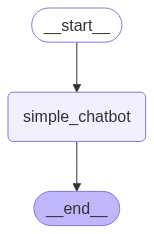

In [11]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [13]:
while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        })

        print("AI: " + result["messages"][-1].content + "\n")

## Adding Tools

In [16]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

In [17]:
class SimpleChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [18]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [19]:
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [20]:
llm_with_tools = llm.bind_tools(tools=tools)

In [21]:
def tool_enabled_chatbot(state: SimpleChatState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 


In [22]:
tool_node = ToolNode(tools=tools)

We can also use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge. Here - we first define a custom router for explanation, but show a streamlined manner just using `tools_condition`.

In [23]:
#From scratch - else use tools_condition
def tools_router(state: SimpleChatState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return "end"

In [24]:
#From scratch - else use tools_condition
graph = StateGraph(SimpleChatState)

graph.add_node("chatbot", tool_enabled_chatbot)
graph.add_node("tools", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", 
                            tools_router,
                           {
                               "tools": "tools",
                               "end": END
                           })
graph.add_edge("tools", "chatbot")

app = graph.compile()

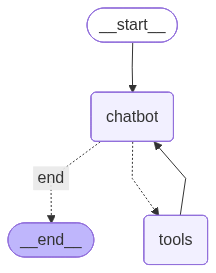

In [25]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [26]:
#Using tools_condition
graph = StateGraph(SimpleChatState)

graph.add_node("chatbot", tool_enabled_chatbot)
graph.add_node("tools", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", 
                            tools_condition)
graph.add_edge("tools", "chatbot")

app = graph.compile()

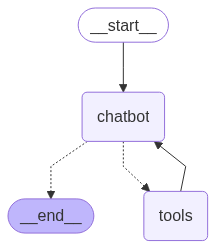

In [27]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [29]:
while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        })

        print("AI: " + result["messages"][-1].content + "\n")

**Question** Who returns a ToolMessage?

## Adding Memory

**We are referring to short-term memory enabled by thread-level persistence here below, and not long-term memory which is across user or applications.**

In [30]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

In [31]:
memory = InMemorySaver()

In [32]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [33]:
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [34]:
llm_with_tools = llm.bind_tools(tools=tools)

In [35]:
tool_node = ToolNode(tools=tools)

In [36]:
class SimpleChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [37]:
def tool_enabled_chatbot(state: SimpleChatState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

In [38]:
#From scratch - else use tools_condition
graph = StateGraph(SimpleChatState)

graph.add_node("chatbot", tool_enabled_chatbot)
graph.add_node("tools", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", 
                            tools_condition)

graph.add_edge("tools", "chatbot")

app = graph.compile(checkpointer=memory)

config = {"configurable": {
    "thread_id": 1
}}

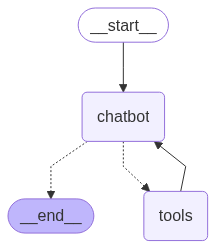

In [39]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [64]:
while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

**With short-term memory, long covnersations can lead to context length being exceeded. Common counteractions include trimming, deleting, summarizing messages and managing checkpoints.**

### Use in Production

**In production, we should use a checkpointer backed by a database.**

In [40]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3 #in built with Python

In [41]:
#Create a connection string
sqlite_conn = sqlite3.connect("checkpoint.sqlite", check_same_thread=False)

In [42]:
#Replace memory saver with SqliteSaver - everything else is same
memory = SqliteSaver(sqlite_conn)

**After every single node execution, this checkpointer will append new checkpoints and save the state.**

In [43]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [44]:
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [45]:
llm_with_tools = llm.bind_tools(tools=tools)

In [46]:
tool_node = ToolNode(tools=tools)

In [47]:
class SimpleChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [48]:
def tool_enabled_chatbot(state: SimpleChatState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

In [49]:
#From scratch - else use tools_condition
graph = StateGraph(SimpleChatState)

graph.add_node("chatbot", tool_enabled_chatbot)
graph.add_node("tools", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", 
                            tools_condition)

graph.add_edge("tools", "chatbot")

app = graph.compile(checkpointer=memory)

config = {"configurable": {
    "thread_id": 1
}}

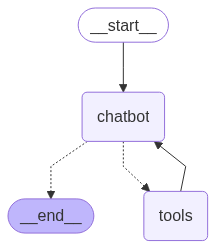

In [50]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [51]:
while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

In [ ]:
#Running again - it is able to recall
while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

In [ ]:
#After deleting, it's not able to recall
while True: 
    user_input = input("User: ")
    if(user_input in ["exit", "end"]):
        break
    else: 
        result = app.invoke({
            "messages": [HumanMessage(content=user_input)]
        }, config=config)

        print("AI: " + result["messages"][-1].content)

User: What did we talk about earlier?
AI: It seems we didn't have a previous conversation. Let's start fresh. How can I assist you today?


**Show example when deleting the SQLite causes the memory to not work - "DELETE FROM checkpoints".**

# Human in the Loop

**Human-in-the-loop** workflow integrates human inputs into automated processes, and is especially useful as LLMs can generate inaccurate content or require more information occasionally:

- **Reviewing tool calls**: Reviewing, editing or approving tools calls requested by the LLM before execution 
- **Validating LLM outputs**: Reviewing, editing or approving content generated by LLM
- **Providing context**: For clarification or more details or to support multi-turn conversations

There are 4 key design patterns:

- **Approve or reject**: Depending on the human's approval or rejection, the graph can proceed with the action or take an alternative path.
<img src="images/approve-or-reject.png" width="30%" height = "30%" alt="Approve or reject">



- **Review and edit state**: A human can review and edit the state of the graph. This is useful for correcting mistakes or updating the state with additional information.
<img src="images/edit-graph-state-simple.png" width="40%" height = "40%" alt="Review and edit state">


- **Review tool calls**: A human can review and edit the output from the LLM before proceeding. This is particularly critical in applications where the tool calls requested by the LLM may be sensitive or require human oversight.
<img src="images/tool-call-review.png" width="40%" height = "40%" alt="Review tool calls">


- **Validating human input**: To validate the input provided by the human within the graph itself (rather than on the client side).

Let's take an example:

<img src="images/human-in-the-loop-example.png" width="20%" height = "20%" alt="Example">

## Basic Working Version

In [52]:
from typing import TypedDict, Annotated
from langchain_core.messages import HumanMessage
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq

In [53]:
class State(TypedDict): 
    messages: Annotated[list, add_messages]

In [54]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [55]:
GENERATE_POST = "generate_post"
GET_REVIEW_DECISION = "get_review_decision"
POST = "post"
COLLECT_FEEDBACK = "collect_feedback"

In [56]:
#Add node
def generate_post(state: State): 
    return {
        "messages": [llm.invoke(state["messages"])]
    }

In [57]:
#Add node
def post(state: State):  
    final_post = state["messages"][-1].content  
    print("\nFinal Tweet:\n")
    print(final_post)
    print("\nTweet has been approved and is now live on Twitter!")

In [58]:
#Add node
def collect_feedback(state: State):  
    feedback = input("How can I improve this tweet?")
    return {
        "messages": [HumanMessage(content=feedback)]
    }

In [59]:
#Add conditional edge
def get_review_decision(state: State):  
    post_content = state["messages"][-1].content 
    
    print("\nCurrent Tweet:\n")
    print(post_content)
    print("\n")

    decision = input("Tweet? (yes/no): ")

    if decision.lower() == "yes":
        return "post"
    else:
        return "collect_feedback"

In [60]:
graph = StateGraph(State)

graph.add_node(GENERATE_POST, generate_post)
graph.add_node(COLLECT_FEEDBACK, collect_feedback)
graph.add_node(POST, post)

graph.set_entry_point(GENERATE_POST)

graph.add_conditional_edges(GENERATE_POST, 
                            get_review_decision,
                           {
                               "post": POST,
                               "collect_feedback": COLLECT_FEEDBACK
                           })
graph.add_edge(COLLECT_FEEDBACK, GENERATE_POST)
graph.add_edge(POST, END)

app = graph.compile()

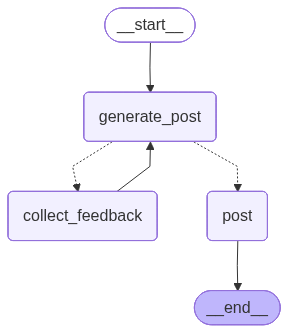

In [61]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [63]:
response = app.invoke({
    "messages": [HumanMessage(content="Write me a Tweet on TrueFoundry launching the MCP (Model Context Protocol) gateway")]
})

print("\n\n", response)

There are several drawbacks of using `input()` function, things like it freezes your program until something's typed, works only in terminals not web apps, can handle only one user at a time, and all progress is deleted if program crashes.

That's why we use the `interrput()` method provided by LangGraph.

## Using interrupt()

**Benefits**:

- Pauses workflow and saves state to pick back up later
- Works in web apps, APIs and other interfaces
- Supports multiple users/sessions concurrently
- Recovers from crashes and handles restarts
- Lets humans take time to respond
- Perfect for human-in-the-loop systems

**There are two ways for using interrupts:**

1. Interrupt in the compile step

`graph = graph_builder.compile(checkpointer=checkpointer, interrupt_before = ["tools"])`
    
2. Interrupt function with command class

`human_review = interrupt(
    {
        "question": "Is this correct?",
        "tool_call": tool_call
    }
)`

`if review_action == "continue":
    return Command(goto = "run_tool")`


**The Command class in LangGraph allows us to create edgeless workflows**.

### Basic Examples for Understanding

#### Example 1

Approve or reject use case with the second way of using `interrupt()` method

In [64]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from typing import TypedDict
from langgraph.checkpoint.memory import MemorySaver

In [65]:
memory = MemorySaver()

In [66]:
class State(TypedDict):
    value: str

In [67]:
def node_a(state: State): 
    print("Node A")
    return Command(
        goto="node_b", 
        update={
            "value": state["value"] + "a"
        }
    )

In [68]:
def node_b(state: State): 
    print("Node B")

    human_response = interrupt("Do you want to go to C or D? Type C/D")

    print("Human Review Values: ", human_response)
    
    if(human_response == "C"): 
        return Command(
            goto="node_c", 
            update={
                "value": state["value"] + "b"
            }
        ) 
    elif(human_response == "D"): 
        return Command(
            goto="node_d", 
            update={
                "value": state["value"] + "b"
            }
        )

In [69]:
def node_c(state: State): 
    print("Node C")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "c"
        }
    )

In [70]:
def node_d(state: State): 
    print("Node D")
    return Command(
        goto=END, 
        update={
            "value": state["value"] + "d"
        }
)

In [71]:
graph = StateGraph(State)

graph.add_node("node_a", node_a)
graph.add_node("node_b", node_b)
graph.add_node("node_c", node_c)
graph.add_node("node_d", node_d)

graph.set_entry_point("node_a") 

app = graph.compile(checkpointer=memory)

In [72]:
config = {"configurable": {"thread_id": "1"}}

In [73]:
initialState = {
    "value": ""
}

In [74]:
first_result = app.invoke(initialState, config, stream_mode="updates")
first_result

Node A
Node B


[{'node_a': {'value': 'a'}},
 {'__interrupt__': (Interrupt(value='Do you want to go to C or D? Type C/D', resumable=True, ns=['node_b:0e55c4b8-59b7-0879-2f81-d62a4237922a']),)}]

In [75]:
#This gives information about the next node to go to, since it is checkpointed
print(app.get_state(config).next)

('node_b',)


In [76]:
#I want to go to C
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
second_result

Node B
Human Review Values:  C
Node C


[{'node_b': {'value': 'ab'}}, {'node_c': {'value': 'abc'}}]

In [77]:
#Running this again, we'll not get anything because the graph has already executed - there's no interrupt method. Either change the thread id and start from scratch / or use time travel
second_result = app.invoke(Command(resume="C"), config=config, stream_mode="updates")
second_result

[]

#### Example 2

Reviewing tool calls and using the first way of using `interrupt` method to check before the tool is actually executed.

In [78]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

In [79]:
memory = InMemorySaver()

In [80]:
class SimpleChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [81]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [82]:
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [83]:
llm_with_tools = llm.bind_tools(tools=tools)

In [84]:
def tool_enabled_chatbot(state: SimpleChatState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 


In [85]:
tool_node = ToolNode(tools=tools)

We can also use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge. Here - we first define a custom router for explanation, but show a streamlined manner just using `tools_condition`.

In [86]:
#Using tools_condition
graph = StateGraph(SimpleChatState)

graph.add_node("chatbot", tool_enabled_chatbot)
graph.add_node("tools", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", 
                            tools_condition)
graph.add_edge("tools", "chatbot")

In [87]:
#This is where there's a change | there's also an interrupt_after that exits the graph after the tool node is executed (another use case)
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

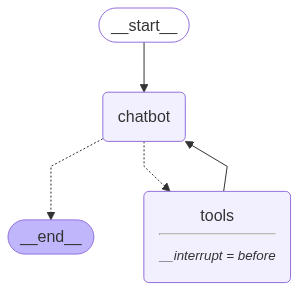

In [88]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [89]:
config = {"configurable": {
    "thread_id": 1
}}

In [90]:
#We'll not use invoke and use stream instead -> invoke returns a value only when the graph has executed, either because of interrupt method or the graph has completed | stream emits events after every single node
events = app.stream({
    "messages": [HumanMessage(content="What is the current weather in Indore?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Indore?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (68hwhd2wn)
 Call ID: 68hwhd2wn
  Args:
    query: Indore current weather
    topic: news


In [91]:
#This will be tools, because the tool node is responsible for executing the tool call
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [92]:
#Executes Tavily search tool
events = app.stream(None, config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (68hwhd2wn)
 Call ID: 68hwhd2wn
  Args:
    query: Indore current weather
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "Indore current weather", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.skynews.com.au/australia-news/weather/showers-likely-to-ease-in-nations-drenched-southwest-corner-after-wet-and-chilly-weekend-for-west-coast/news-story/5d5b6f94988edc1ffbffb0f9e43ea9d8", "title": "Showers likely to ease in drenched and chilly south-west - Sky News Australia", "score": 0.1591785, "published_date": "Sun, 07 Sep 2025 19:18:43 GMT", "content": "Skies are expected to gradually clear in the country’s south-west corner following a wet and chilly weekend for much of the west coast. Examining the forecast for the start of the week, Sky News Weather Present

#### Example 3 - Coming back to our main example in this section

Multi-turn conversations and reuse the Tweet creation example

In [93]:
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.types import Command, interrupt
from typing import TypedDict, Annotated, List
from langgraph.checkpoint.memory import MemorySaver
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
import uuid

In [94]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [95]:
class State(TypedDict): 
    tweet_topic: str #in the beginning
    generated_post: Annotated[List[str], add_messages] #every time the model created the post
    human_feedback: Annotated[List[str], add_messages] #every time there's a feedback

In [96]:
def model(state: State): 
    """ Here, we're using the LLM to generate a Twitter post with human feedback incorporated """

    print("[model] Generating content")
    tweet_topic = state["tweet_topic"]
    feedback = state["human_feedback"] if "human_feedback" in state else ["No Feedback yet"]

    # Here, we define the prompt 

    prompt = f"""

        Tweet Topic: {tweet_topic}
        Human Feedback: {feedback[-1] if feedback else "No feedback yet"}

        Generate a structured and well-written Twitter post based on the given topic.

        Consider previous human feedback to refine the reponse. 
    """

    response = llm.invoke([
        SystemMessage(content="You are an expert Twitter content writer"), 
        HumanMessage(content=prompt)
    ])

    generated_twitter_post = response.content

    print(f"[model_node] Generated post:\n{generated_twitter_post}\n")

    return {
       "generated_post": [AIMessage(content=generated_twitter_post)] , 
       "human_feedback": feedback
    }

In [97]:
def human_node(state: State): 
    """Human Intervention node - loops back to model unless input is done"""

    print("\n [human_node] awaiting human feedback...")

    generated_post = state["generated_post"]

    # Interrupt to get user feedback

    user_feedback = interrupt(
        {
            "generated_post": generated_post, 
            "message": "Provide feedback or type 'done' to finish"
        }
    )

    print(f"[human_node] Received human feedback: {user_feedback}")

    # If user types "done", transition to END node
    if user_feedback.lower() == "done": 
        return Command(update={"human_feedback": state["human_feedback"] + ["Finalised"]}, goto="end_node")

    # Otherwise, update feedback and return to model for re-generation
    return Command(update={"human_feedback": state["human_feedback"] + [user_feedback]}, goto="model")

In [98]:
def end_node(state: State): 
    """ Final node """
    print("\n[end_node] Process finished")
    print("Final Generated Post:", state["generated_post"][-1])
    print("Final Human Feedback", state["human_feedback"])
    return {"generated_post": state["generated_post"], "human_feedback": state["human_feedback"]}

In [99]:
# Buiding the Graph

graph = StateGraph(State)
graph.add_node("model", model)
graph.add_node("human_node", human_node)
graph.add_node("end_node", end_node)

graph.set_entry_point("model")

In [100]:
# Define the flow

graph.add_edge(START, "model")
graph.add_edge("model", "human_node")

graph.set_finish_point("end_node")

In [101]:
# Enable Interrupt mechanism
checkpointer = MemorySaver()
app = graph.compile(checkpointer=checkpointer)

In [102]:
# display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [103]:
thread_config = {"configurable": {
    "thread_id": uuid.uuid4()
}}

In [107]:
tweet_topic = input("Enter your Tweet topic: ")
initial_state = {
    "tweet_topic": tweet_topic, 
    "generated_post": [], 
    "human_feedback": []
}

Enter your Tweet topic:  AI Gateway


In [108]:
for chunk in app.stream(initial_state, config=thread_config):
    for node_id, value in chunk.items():
        #  If we reach an interrupt, continuously ask for human feedback

        if(node_id == "__interrupt__"):
            while True: 
                user_feedback = input("Provide feedback (or type 'done' when finished): ")

                # Resume the graph execution with the user's feedback
                app.invoke(Command(resume=user_feedback), config=thread_config)

                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break

[model] Generating content
[model_node] Generated post:
Since there is no previous human feedback, I will generate a basic structured and well-written Twitter post based on the topic 'AI Gateway'.

**Tweet:**

1. **Catchy Title:** 
"Unlock the Future of Tech: Discover the AI Gateway Revolutionizing Industries! "

2. **Content:**
"Imagine a world where machines can learn, adapt, and interact seamlessly. Introducing the AI Gateway - a cutting-edge technology bridging the gap between humans and artificial intelligence. 

From enhanced customer experiences to optimized business processes, the AI Gateway is transforming industries at an unprecedented pace. 

Ready to unlock the full potential of AI? Let's dive into the world of AI Gateway and explore its limitless possibilities! #AIGateway #ArtificialIntelligence #TechRevolution"

3. **Visuals:** Add an eye-catching image or GIF that represents AI Gateway technology. This could be an illustration of a person interacting with a futuristic AI

Provide feedback (or type 'done' when finished):  done



 [human_node] awaiting human feedback...
[human_node] Received human feedback: done

[end_node] Process finished
Final Generated Post: content='Since there is no previous human feedback, I will generate a basic structured and well-written Twitter post based on the topic \'AI Gateway\'.\n\n**Tweet:**\n\n1. **Catchy Title:** \n"Unlock the Future of Tech: Discover the AI Gateway Revolutionizing Industries! "\n\n2. **Content:**\n"Imagine a world where machines can learn, adapt, and interact seamlessly. Introducing the AI Gateway - a cutting-edge technology bridging the gap between humans and artificial intelligence. \n\nFrom enhanced customer experiences to optimized business processes, the AI Gateway is transforming industries at an unprecedented pace. \n\nReady to unlock the full potential of AI? Let\'s dive into the world of AI Gateway and explore its limitless possibilities! #AIGateway #ArtificialIntelligence #TechRevolution"\n\n3. **Visuals:** Add an eye-catching image or GIF that re

# Streaming

In [109]:
from IPython.display import Image, display
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition

In [110]:
class SimpleChatState(TypedDict):
    messages: Annotated[list, add_messages]

In [111]:
llm = ChatGroq(model="llama-3.1-8b-instant")

In [112]:
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

In [113]:
llm_with_tools = llm.bind_tools(tools=tools)

In [114]:
def tool_enabled_chatbot(state: SimpleChatState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])], 
    }

We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 


In [115]:
tool_node = ToolNode(tools=tools)

We can also use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge. Here - we first define a custom router for explanation, but show a streamlined manner just using `tools_condition`.

In [116]:
#From scratch - else use tools_condition
def tools_router(state: SimpleChatState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tools"
    else: 
        return "end"

In [117]:
#Using tools_condition
graph = StateGraph(SimpleChatState)

graph.add_node("chatbot", tool_enabled_chatbot)
graph.add_node("tools", tool_node)
graph.set_entry_point("chatbot")

graph.add_conditional_edges("chatbot", 
                            tools_condition)
graph.add_edge("tools", "chatbot")

app = graph.compile()

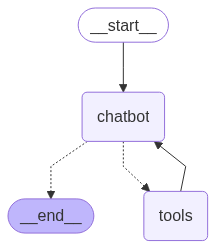

In [118]:
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [119]:
## From earlier --> 
# result = app.invoke({
#     "messages": [HumanMessage(content=user_input)]
# })

# print("AI: " + result["messages"][-1].content + "\n")

In [120]:
input = {
    "messages": ["What's the current weather in Indore?"]
}

#Stream model to values means that after execution of every node, an event will be emitted showing us the entire state at that point
events = app.stream(input=input, stream_mode="values")

#For every event from the generator, we'll see the event
for event in events: 
    print(event["messages"], "\n\n")

[HumanMessage(content="What's the current weather in Indore?", additional_kwargs={}, response_metadata={}, id='ae32f409-7610-498e-86c9-93b48bbc9edc')] 


[HumanMessage(content="What's the current weather in Indore?", additional_kwargs={}, response_metadata={}, id='ae32f409-7610-498e-86c9-93b48bbc9edc'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'dbmd5es38', 'function': {'arguments': '{"query":"Indore current weather","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1795, 'total_tokens': 1820, 'completion_time': 0.041766137, 'prompt_time': 0.418882558, 'queue_time': 0.047633141, 'total_time': 0.460648695}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5518d852-6fa2-43eb-8526-b1ad1165a793-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Indore c

In [121]:
input = {
    "messages": ["What's the current weather in Bangalore?"]
}

#Updates gives the new item that has been added to the list, and which node did the change
events = app.stream(input=input, stream_mode="updates")

for event in events: 
    print(event, "\n\n")

{'chatbot': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'efmexm4yw', 'function': {'arguments': '{"query":"Bangalore current weather","topic":"general"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1794, 'total_tokens': 1819, 'completion_time': 0.04794163, 'prompt_time': 0.345000874, 'queue_time': 0.079784165, 'total_time': 0.392942504}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_46fc01befd', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5c15bbcd-b9aa-4bde-9f84-3e3ac5644b7d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Bangalore current weather', 'topic': 'general'}, 'id': 'efmexm4yw', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1794, 'output_tokens': 25, 'total_tokens': 1819})]}} 


{'tools': {'messages': [ToolMessage(content='{"query": "Bangalore current weather", "follow_up_question

In [122]:
input = {
    "messages": ["Hi, how are you?"]
}

#Stream the events as they happen inside the node, not at the end of the node! And use latest version - v2.  
events = app.astream_events(input=input, version="v2")

# Async is used because this is an asynchronous operation.
async for event in events: 
    print(event, "\n\n")

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, how are you?']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '3c70990f-0475-4571-b48a-d31e485d7115', 'metadata': {}, 'parent_ids': []} 


{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='31a14430-1b55-45ee-8309-7410406bf172')]}}, 'name': 'chatbot', 'tags': ['graph:step:1'], 'run_id': 'fac07a1c-0549-4921-b162-216bb7a0ad8d', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'chatbot', 'langgraph_triggers': ('branch:to:chatbot',), 'langgraph_path': ('__pregel_pull', 'chatbot'), 'langgraph_checkpoint_ns': 'chatbot:a64b279e-f133-ba4c-0ecc-28fa66ab8216'}, 'parent_ids': ['3c70990f-0475-4571-b48a-d31e485d7115']} 


{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='31a14430-1b55-45ee-8309-7410406bf172')]]}}, 'name': 'ChatGroq',

In [123]:
input = {
    "messages": ["Hi, how are you? Tell me everything!"]
}

#Stream the events as they happen inside the node, not at the end of the node!
events = app.astream_events(input=input, version="v2")

#We are only interested in the streams emitted by the LLM - on_chat_model_stream
async for event in events: 
    if event["event"] == "on_chat_model_stream":
        print(event["data"]["chunk"].content, end="", flush=True) #Flush everything from the buffer as and when some value is stored in it
        
#We can also add langgraph_node as a condition, and then stream to the UI!

I'm a large language model, so I don't have a physical body or emotions. However, I'm functioning properly and ready to assist you with any questions or information you may need. What would you like to talk about or learn today?